<img src="images/logos/wradlib_logo.svg.png" width=250 alt="wradlib logo png" align="left"></img>

# wradlib data quality

---

## Overview

Within this notebook, we will cover:

1. Reading radar volume data into xarray based RadarVolume
1. Examination of RadarVolume and Sweeps
1. Plotting of sweeps

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Helpful | Projections |
| [Matplotlib Basics](https://foundations.projectpythia.org/core/matplotlib/matplotlib-basics.html) | Helpful | Basic Plotting |
| [Xarray Basics](https://tutorial.xarray.dev/intro.html) | Helpful | Basic Dataset/DataArray |

- **Time to learn**: 10 minutes

---

## Imports

In [1]:
import numpy as np
import glob
import itertools

import wradlib as wrl
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Get hold of some  some Australien Radar Data

It is assumed, that data from IDR71 (Sidney) from 20th of December 2018 is used in this notebook.

In [2]:
fglob = '/home/kai/daten/daten/radar_all_over_the_world/terryhills/71_20181220*.h5'
idr71 = glob.glob(fglob)
idr71.sort()
print("Files available: {}".format(len(idr71)))

Files available: 40


## Open ODIM_H5 Volume


In [3]:
odh = wrl.io.open_odim_dataset(idr71[24])

In [4]:
display(odh)

<wradlib.RadarVolume>
Dimension(s): (sweep: 14)
Elevation(s): (0.5, 0.9, 1.3, 1.8, 2.4, 3.1, 4.2, 5.6, 7.4, 10.0, 13.3, 17.9, 23.9, 32.0)

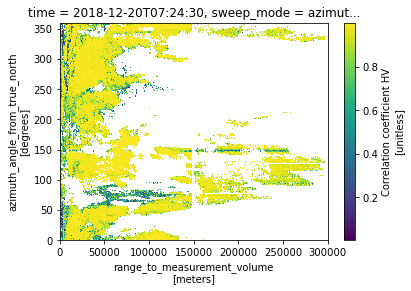

In [5]:
odh[0].RHOHV.plot()

In [6]:
def extract_clutter(ds):
    clmap = wrl.clutter.filter_gabella(ds.TH.values,
                                       wsize=5,
                                       thrsnorain=0.,
                                       tr1=6.,
                                       n_p=8,
                                       tr2=1.3, 
                                       rm_nans=False)
    ds = ds.assign({'CMAP': (ds.DBZH.dims, clmap)})
    return ds

In [7]:
swp = odh[0].pipe(extract_clutter)
swp

<xarray.Dataset>
Dimensions:     (azimuth: 360, range: 1200)
Coordinates:
  * azimuth     (azimuth) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    elevation   (azimuth) float32 ...
    rtime       (azimuth) datetime64[ns] ...
  * range       (range) float32 125.0 375.0 625.0 ... 2.996e+05 2.999e+05
    time        datetime64[ns] 2018-12-20T07:24:30
    sweep_mode  <U20 ...
    longitude   float64 ...
    latitude    float64 ...
    altitude    float64 ...
Data variables:
    DBZH        (azimuth, range) float32 ...
    DBZH_CLEAN  (azimuth, range) float32 ...
    VRADDH      (azimuth, range) float32 ...
    VRADH       (azimuth, range) float32 ...
    WRADH       (azimuth, range) float32 ...
    TH          (azimuth, range) float32 12.5 11.5 2.5 16.0 ... nan nan nan nan
    ZDR         (azimuth, range) float32 ...
    RHOHV       (azimuth, range) float32 ...
    PHIDP       (azimuth, range) float32 ...
    KDP         (azimuth, range) float32 ...
    SNRH        (azimuth, range) float32 ...
    CMAP        (azimuth, range) bool False False False ... False False False
Attributes:
    fixed_angle:  0.5

Text(0.5, 1.0, 'Cluttermap')

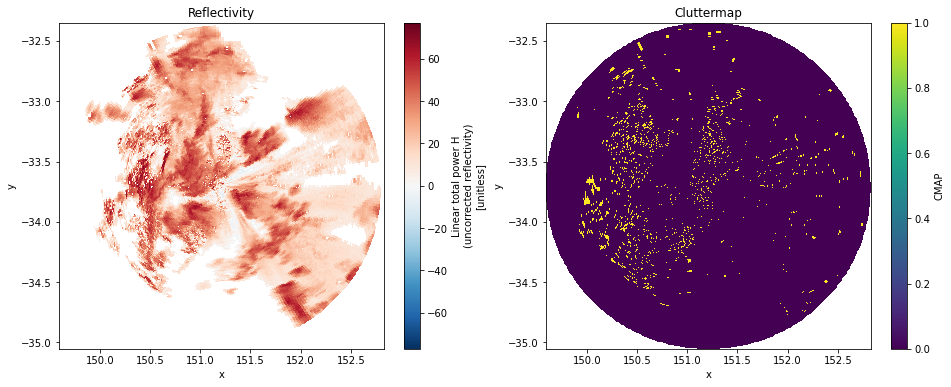

In [10]:
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(121)
from osgeo import osr
wgs84 = osr.SpatialReference()
wgs84.ImportFromEPSG(4326)
swpx = swp.sel(range=slice(0, 150000)).pipe(wrl.georef.georeference_dataset, proj=wgs84)
swpx.TH.where(swpx.CMAP<1).plot(x="x", y="y", ax=ax1)
ax1.set_title('Reflectivity')
ax2 = fig.add_subplot(122)
swpx.CMAP.plot(x="x", y="y", ax=ax2)
ax2.set_title('Cluttermap')

In [11]:
extent = wrl.zonalstats.get_bbox(swpx.x.values, swpx.y.values)
extent

{'left': 149.59284279545557,
 'right': 152.8251572019685,
 'bottom': -35.051406103166165,
 'top': -32.34990051750654}

In [13]:
import os
os.environ["WRADLIB_EARTHDATA_USER"] = "kai.muehlbauer@uni-bonn.de"
os.environ["WRADLIB_EARTHDATA_PASS"] = "km#eARt:20"
dem = wrl.io.get_srtm(extent.values())

In [14]:
dem

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f08a3ba04b0> >

---

## Summary
We've just learned how to use $\omega radlib$'s xarray backends to make radar volume data available as xarray Datasets and DataArrays. Accessing, plotting and exporting data has been shown.

### What's next?
In the next notebook we dive into data quality processing.

## Resources and references

- [xarray](https://docs.xarray.dev)
- [dask](https://docs.dask.org/)
- [wradlib xarray backends](https://docs.wradlib.org/en/stable/notebooks/fileio/wradlib_xarray_backends.html)
- [Leonardo - Rainbow5](https://electronics.leonardo.com/en/products/rainbow-5-application-software)
- [OPERA ODIM_H5](https://www.eumetnet.eu/activities/observations-programme/current-activities/opera/)
- [WMO JET-OWR](https://community.wmo.int/governance/commission-membership/commission-observation-infrastructure-and-information-systems-infcom/commission-infrastructure-officers/infcom-management-group/standing-committee-measurements-instrumentation-and-traceability-sc-mint/joint-expert-team)